### 1) Carregando os dados e bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
import re
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.stats import uniform
from xgboost import XGBClassifier

pd.set_option('display.max_colwidth', None)

c:\Users\bruno\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df = pd.read_json('corpusTT.json', orient = 'index')

In [4]:
nlp = spacy.load('pt_core_news_lg')

### 2) EDA

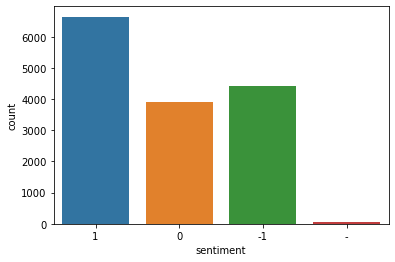

In [494]:
sns.countplot(data=df,x = 'sentiment');

In [495]:
words = []
with open('stopwords.txt', 'r') as f:
    [words.append(word) for line in f for word in line.split()]

In [496]:
def plot_wordcloud(df,sentimento):
    df_aux=df.loc[df['sentiment'] == str(sentimento)]
    str_aux = ' '.join(df_aux['text'])
    all_stopwords = nlp.Defaults.stop_words
    wordcloud = WordCloud(width=1100,height=800, min_font_size=10, background_color='white', stopwords=all_stopwords).generate(str_aux)
    fig, ax = plt.subplots(figsize=(18, 9))
    ax.imshow(wordcloud)
    ax.axis('off')
    plt.tight_layout()

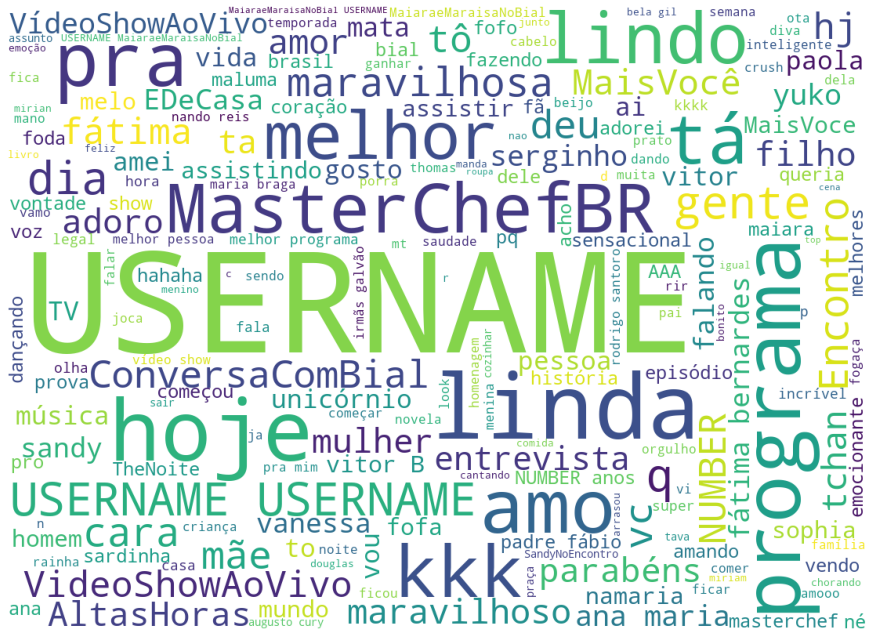

In [497]:
plot_wordcloud(df,1)

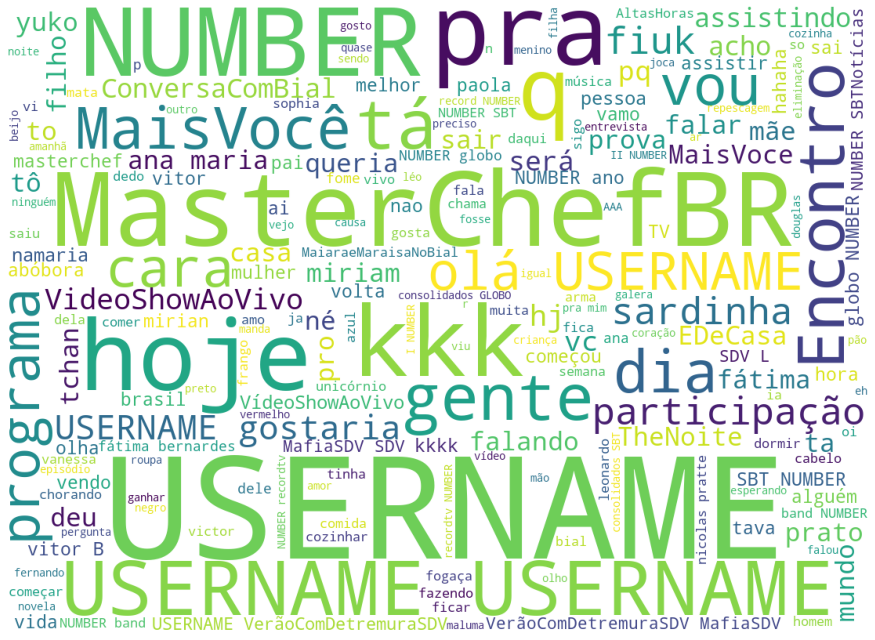

In [498]:
plot_wordcloud(df,0)

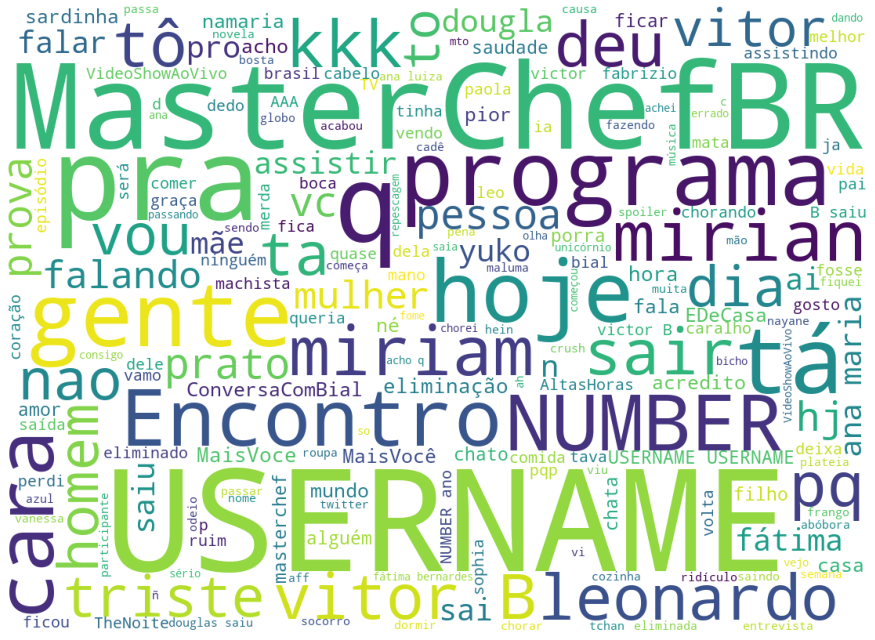

In [499]:
plot_wordcloud(df,-1)

In [500]:
nlp = spacy.load('pt_core_news_lg')

In [501]:
doc = nlp(df.text[34])
spacy.displacy.render(doc, style="ent")
doc_substantivos = list(doc.noun_chunks)
print(doc_substantivos)

[drauzio varella, a verdadeira dinâmica, cadeia, brasil, todos, ConversaComBial]


In [502]:
[(token.orth_,token.pos_) for token in doc if not token.is_punct]

[('drauzio', 'PROPN'),
 ('varella', 'PROPN'),
 ('mostrando', 'VERB'),
 ('como', 'ADV'),
 ('funciona', 'VERB'),
 ('a', 'DET'),
 ('verdadeira', 'ADJ'),
 ('dinâmica', 'NOUN'),
 ('na', 'ADP'),
 ('cadeia', 'NOUN'),
 ('no', 'ADP'),
 ('brasil', 'PROPN'),
 ('é', 'AUX'),
 ('bom', 'ADJ'),
 ('que', 'SCONJ'),
 ('todos', 'PRON'),
 ('assistam', 'VERB'),
 ('ConversaComBial', 'NOUN')]

In [503]:
doc = nlp(df.text[34])
for token in doc:
   print(token.text, token.dep_, token.head.text, token.head.pos_,
   token.pos_,[child for child in token.children])

drauzio nsubj mostrando VERB PROPN [varella]
varella flat:name drauzio PROPN PROPN []
mostrando csubj bom ADJ VERB [drauzio, funciona]
como mark funciona VERB ADV []
funciona ccomp mostrando VERB VERB [como, dinâmica, cadeia]
a det dinâmica NOUN DET []
verdadeira amod dinâmica NOUN ADJ []
dinâmica obj funciona VERB NOUN [a, verdadeira]
na case cadeia NOUN ADP []
cadeia obl funciona VERB NOUN [na, brasil]
no case brasil PROPN ADP []
brasil nmod cadeia NOUN PROPN [no]
é cop bom ADJ AUX []
bom ROOT bom ADJ ADJ [mostrando, é, assistam, ConversaComBial]
que mark assistam VERB SCONJ []
todos nsubj assistam VERB PRON []
assistam csubj bom ADJ VERB [que, todos, #]
# obj assistam VERB PART []
ConversaComBial obl bom ADJ NOUN []


In [504]:
[token.lemma_ for token in doc if token.pos_ == 'VERB']

['mostrar', 'funcionar', 'assister']

In [505]:
doc = nlp(u'dormi,dormir,dormirei,dormindo,dormirão,dormiram,dormiu')

In [506]:
[token.lemma_ for token in doc if token.pos_ == 'VERB']

['dormi', 'dormir', 'dormir', 'dormir', 'dormir', 'dormir', 'dormir']

In [507]:
for word in doc:
    print(word.text,  word.pos_, word.dep_)

dormi VERB ROOT
, PUNCT punct
dormir VERB conj
, PUNCT punct
dormirei VERB conj
, PUNCT punct
dormindo VERB advcl
, PUNCT punct
dormirão VERB conj
, PUNCT punct
dormiram VERB conj
, PUNCT punct
dormiu VERB conj


In [508]:
for word in doc:
    print(word.text,  word.pos_, word.lemma_)

dormi VERB dormi
, PUNCT ,
dormir VERB dormir
, PUNCT ,
dormirei VERB dormir
, PUNCT ,
dormindo VERB dormir
, PUNCT ,
dormirão VERB dormir
, PUNCT ,
dormiram VERB dormir
, PUNCT ,
dormiu VERB dormir


In [509]:
tokens = [token for token in doc]
tokens[0].similarity(tokens[6])

0.6971142888069153

In [510]:
tokens[0].is_ancestor(tokens[3])

True

### 3) Removendo Stopwords, Lemmatization e Tokenization

In [ ]:
#testar tokenização tfidf

In [5]:
df.drop(df.loc[df['sentiment'] == '0'].index, inplace = True)
df.drop(df.loc[df['sentiment'] == '-'].index, inplace = True)

In [6]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^\w\s]','',x)))

In [7]:
all_stopwords = nlp.Defaults.stop_words
df["text"] = df['text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))

In [8]:
df.loc[df['sentiment'] == '-1','sentiment'] = 0
df['sentiment'] = df.sentiment.astype(int)

In [9]:
df = df[['text','sentiment']]

In [10]:
df.reset_index(drop=True, inplace=True)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(
        encoding="latin-1",
        strip_accents='ascii',
        lowercase=True, 
        min_df= 0.01,
        ngram_range=(1,3),
    )

X = df['text'].values
X  = np.array(tf_idf.fit_transform(X).todense())

(11074, 90)


In [517]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

my_texts = list(map(sequence_to_text, X))

In [518]:
X = pad_sequences(X)

In [16]:
Y = (df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7751, 90) (7751,)
(3323, 90) (3323,)


### 4) XGBoost

In [17]:
param_dist = {"learning_rate": uniform(0, 2),
              "gamma": uniform(1, 0.000001),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10),
              'n_jobs': range(1,5)}

In [18]:
rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_dist, n_iter=3)

In [19]:
xgb  = Pipeline([
    ('model', rs)
])

In [20]:
xgb.fit(X_train, Y_train)

c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:46:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:47:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\bruno\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:48:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('model',
                 RandomizedSearchCV(estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            enable_categorical=False,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type=None,
                                                            interaction_constraints=None,
                                                            learning_rate=None,
                                                            max_delta_step=None,
         

In [21]:
predictions=rs.predict(X_test)

In [22]:
predictions

array([1, 0, 1, ..., 1, 1, 0])

In [23]:
print('Model Accuracy: ', round(accuracy_score(Y_test, predictions)*100,2), '%')

Model Accuracy:  69.4 %


In [24]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.51      0.57      1315
           1       0.72      0.81      0.76      2008

    accuracy                           0.69      3323
   macro avg       0.68      0.66      0.67      3323
weighted avg       0.69      0.69      0.69      3323



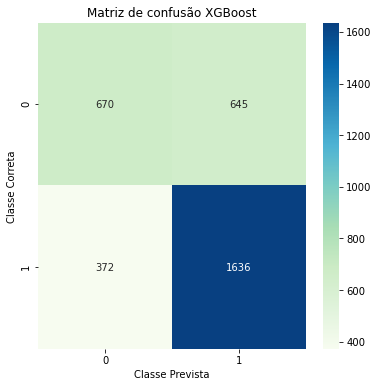

In [25]:
confusion_matrix(Y_test, predictions)

conf_matrix = confusion_matrix(Y_test, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = 'GnBu');
plt.title("Matriz de confusão XGBoost")
plt.ylabel('Classe Correta')
plt.xlabel('Classe Prevista')
plt.show()

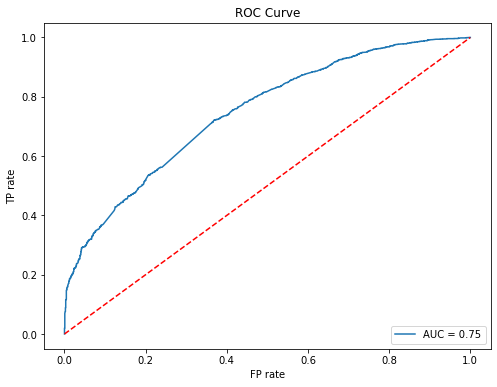

In [26]:
y_pred_proba = xgb.predict_proba(X_test)[:,1]
fp_r, tp_r, t = roc_curve(Y_test, y_pred_proba)
auc = auc(fp_r, tp_r)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

### 5) Random Forest Classifier

In [27]:
rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)

RandomForestClassifier()

In [28]:
predictions=rfc.predict(X_test)

In [29]:
print('Model Accuracy: ', round(accuracy_score(Y_test, predictions)*100,2), '%')

Model Accuracy:  69.79 %


In [30]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.54      0.59      1315
           1       0.73      0.80      0.76      2008

    accuracy                           0.70      3323
   macro avg       0.68      0.67      0.67      3323
weighted avg       0.69      0.70      0.69      3323



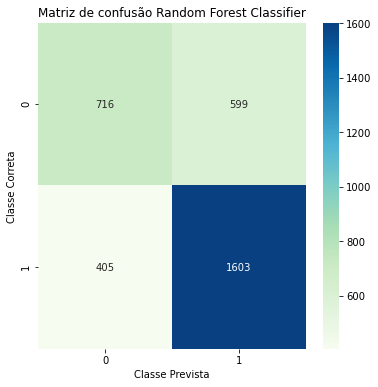

In [31]:
confusion_matrix(Y_test, predictions)

conf_matrix = confusion_matrix(Y_test, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = 'GnBu');
plt.title("Matriz de confusão Random Forest Classifier")
plt.ylabel('Classe Correta')
plt.xlabel('Classe Prevista')
plt.show()

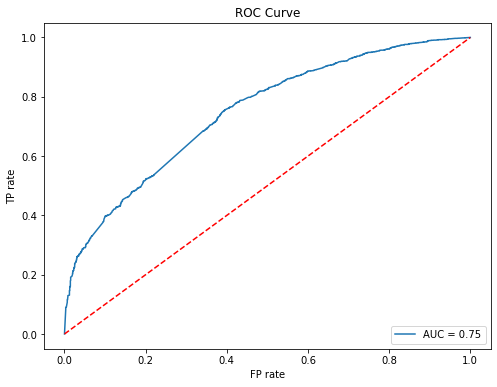

In [32]:
y_pred_proba = rfc.predict_proba(X_test)[:,1]
fp_r, tp_r, t = roc_curve(Y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fp_r, tp_r, label="AUC = %.2f" % auc)
plt.plot([0,1],[0,1],"r--")
plt.ylabel("TP rate")
plt.xlabel("FP rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

### 6) LSTM

In [34]:
embed_dim = 128
lstm_out = 256
max_features = 3000

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.15))
model.add(LSTM(lstm_out, dropout=0.15, recurrent_dropout=0.15))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 128)           384000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 90, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 778,754
Trainable params: 778,754
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
Y = np.array(pd.get_dummies((df['sentiment']).values))
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

In [36]:
X_train

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.5741346,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [37]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 50, batch_size=batch_size, verbose = 2, shuffle=False)

Epoch 1/50
243/243 - 79s - loss: 0.6754 - accuracy: 0.5977 - 79s/epoch - 324ms/step
Epoch 2/50
243/243 - 77s - loss: 0.6742 - accuracy: 0.5986 - 77s/epoch - 316ms/step
Epoch 3/50
243/243 - 76s - loss: 0.6739 - accuracy: 0.5984 - 76s/epoch - 314ms/step
Epoch 4/50
243/243 - 71s - loss: 0.6738 - accuracy: 0.5982 - 71s/epoch - 294ms/step
Epoch 5/50
243/243 - 71s - loss: 0.6731 - accuracy: 0.5980 - 71s/epoch - 294ms/step
Epoch 6/50
243/243 - 71s - loss: 0.6763 - accuracy: 0.5959 - 71s/epoch - 293ms/step
Epoch 7/50
243/243 - 75s - loss: 0.6744 - accuracy: 0.5985 - 75s/epoch - 310ms/step
Epoch 8/50
243/243 - 75s - loss: 0.6741 - accuracy: 0.5986 - 75s/epoch - 311ms/step
Epoch 9/50


KeyboardInterrupt: 

dict_keys(['loss', 'accuracy'])


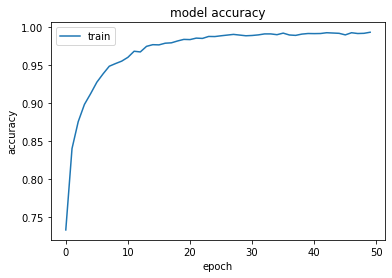

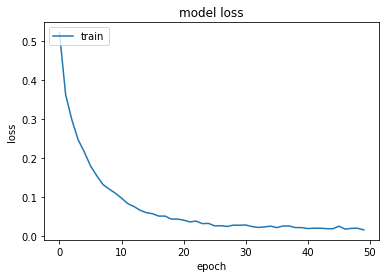

In [540]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [541]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.3f" % (score))
print("acc: %.3f" % (acc*100))

57/57 - 2s - loss: 2.1020 - accuracy: 0.7630 - 2s/epoch - 29ms/step
score: 2.102
acc: 76.303


In [542]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
y_test_max=np.argmax(Y_test,axis=1)

57/57 [==============================] - 2s 24ms/step


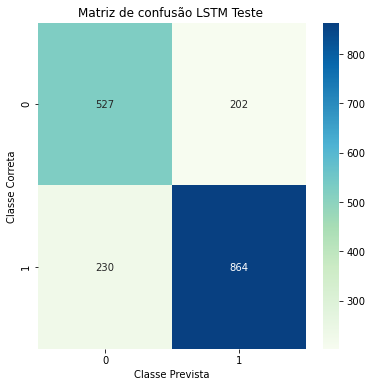

In [543]:
confusion_matrix(y_test_max, classes_x)

conf_matrix = confusion_matrix(y_test_max, classes_x)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = 'GnBu');
plt.title("Matriz de confusão LSTM Teste ")
plt.ylabel('Classe Correta')
plt.xlabel('Classe Prevista')
plt.show()

In [544]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
resultados = []
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 3)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
    
    resultados.append(np.argmax(result))


pos_acc = pos_correct/pos_cnt*100
neg_acc = neg_correct/neg_cnt*100
ovr_acc = (pos_correct + neg_correct)/(neg_cnt + pos_cnt)*100

print(f"pos_acc {pos_acc:.3f} %")
print(f"neg_acc {neg_acc:.3f} %")
print(f"ovr_acc {ovr_acc:.3f} %")

pos_acc 79.212 %
neg_acc 70.137 %
ovr_acc 75.667 %


In [545]:
Y_val_argmax = np.argmax(Y_validate,axis=1)
Y_val_argmax  = Y_val_argmax.reshape(-1,1)
resultados = np.asarray(resultados)
resultados  = resultados.reshape(-1,1)
print(classification_report(Y_val_argmax, resultados))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       586
           1       0.81      0.79      0.80       914

    accuracy                           0.76      1500
   macro avg       0.74      0.75      0.75      1500
weighted avg       0.76      0.76      0.76      1500



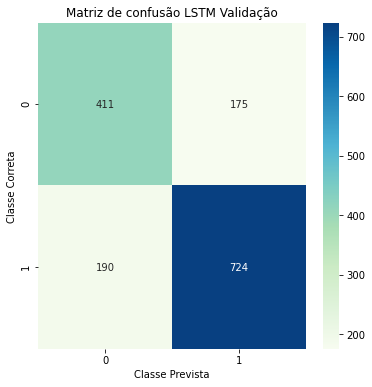

In [546]:
confusion_matrix(Y_val_argmax, resultados)

conf_matrix = confusion_matrix(Y_val_argmax, resultados)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = 'GnBu');
plt.title("Matriz de confusão LSTM Validação")
plt.ylabel('Classe Correta')
plt.xlabel('Classe Prevista')
plt.show()

In [547]:
real = []
for y in Y_validate:
    real.append(np.argmax(y))
df_resultados = pd.DataFrame(list(zip(my_texts, resultados, real)),
               columns =['tokens', 'predição','real'])
df_resultados.head(50)

,tokens,predição,real
0,"[lindo, programa, mostrar, familia, adotar, adolescente, number, ano, amor]",[0],1
1,"[irmã, galvão, adoreer]",[0],0
2,"[mr, catra, username, lançar, música, ppk, chorar, username, k, k, k, mrcatra]",[1],1
3,"[tô, passado, cara, quanta, merda, sair, boca, alguém, minuto]",[1],1
4,"[cibele, arrasar, humilhar]",[0],0
5,"[coitado, namorada]",[1],0
6,"[japa, entendir, porra, orquídea]",[0],1
7,"[famoso, brasil, edecasa, username, lindo]",[1],1
8,"[username, powercouplebrasil, username, reality, dr, rey, tá]",[0],1
9,"[q, passar, entrevista, praça]",[1],1


In [548]:
df_resultados.tail(50)

,tokens,predição,real
1450,"[tchan, ta, louco, washington, único, presidente, brasil]",[1],1
1451,"[tomar, leo, lins]",[1],1
1452,"[arrasar, eliminação, doug, capítulo, foda]",[1],1
1453,"[cade, comentarista, hoje]",[0],0
1454,"[vitor, b, começar, torcer, yuko, descer]",[1],0
1455,"[ser, programa, acabar, pra]",[0],0
1456,"[bom, pessoa, sophia, abrahão, estar, atrasado, chegar, arrasar, divertido, vídeo, show, hoje]",[1],0
1457,"[q, c, nadessa, sair, ir, parar, programa, graça, q, amo, powercouplebrasil]",[0],0
1458,"[falar, irmã, cecília]",[0],0
1459,"[homem, chorar, chorar, username]",[0],1
